# Vector plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

# To work with self-written modules, the paths of the modules directories have to be added
from pathlib import Path
import sys
icon_vis_dir = Path.cwd().parent
sys.path.insert(1,str(Path(icon_vis_dir,'data')))
sys.path.insert(1,str(Path(icon_vis_dir,'modules')))
sys.path.insert(1,str(icon_vis_dir / "modules" / "formatoptions"))

In [4]:
from get_data import get_example_data
from grid import combine_grid_information

In [5]:
# custom formatoptions import
import lakes
import borders
import rivers
import meanmaxwind
import standardtitle

In [6]:
# import modules required for data interpolation
import interpolate

In [7]:
get_example_data()

 
Getting data from folder: grib
 
Getting data from folder: grids
 
Getting data from folder: nc


In [8]:
f_icon      = "../data/example_data/nc/lfff00000000z"
gridfile = '../data/example_data/grids/icon_grid_0001_R19B08_L.nc'

In [9]:
ds = psy.open_dataset(f_icon)
ds

<xarray.Dataset>
Dimensions:    (ncells: 1028172, vertices: 3, alt: 9, time: 2)
Coordinates:
    clon       (ncells) float32 ...
    clon_bnds  (ncells, vertices) float32 ...
    clat       (ncells) float32 ...
    clat_bnds  (ncells, vertices) float32 ...
  * alt        (alt) float64 1.05e+04 8.5e+03 5e+03 4e+03 ... 1e+03 750.0 500.0
  * time       (time) datetime64[ns] 2021-11-23 2021-11-23T01:00:00
Dimensions without coordinates: ncells, vertices
Data variables:
    T          (time, alt, ncells) float32 ...
    U          (time, alt, ncells) float32 ...
    V          (time, alt, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  1
    uuidOfHGrid:          fc046f09-ed97-850e-1e31-8927421b2b60
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-nwp.git@fc1687821dd240...
    history:              /perm/ms/ch/chaw/misc/src/icon-nwp/2.6.2-nwp2/bin/i...
    references:           see MPIM/DWD publications
    comment:              unknown user name on nid00527 (Linux 3.0.101-0.46.1...

In [10]:
# Dont plot with x and y gridlines
psy.rcParams["plotter.maps.xgrid"] = True
psy.rcParams["plotter.maps.ygrid"] = True
psy.rcParams["plotter.maps.grid_settings"] = {'visible': False}
psy.rcParams["plotter.maps.grid_labelsize"] = 'x-small'

In [11]:
from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D, LonLatBox, MapPlotter
from psyplot.plotter import Plotter
import psy_simple.plotters
import psy_maps.plotters
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### Remap ICON grid to Regular grid for wind plotting

ICON data can be too dense to plot wind barbs nicely, so to reduce the density of barbs, we can first interpolate the data to regular grid. See example at bottom of notebook, plotting uninterpolated data.

#### Fieldextra interpolation

In [34]:
output_file = interpolate.remap_ICON_to_regulargrid(
                                        data_file=f_icon,
                                        in_grid_file=gridfile,
                                        num_dates=ds.time.shape[0], # number of time steps in your data.
                                        region='europe' # 'switzerland'/'ch' or 'europe'
                                    )

Creating regular grid over Europe region.

Fieldextra Namelist saved to:/scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/NAMELIST_ICON_REG_REMAP

Running fieldextra:/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp /scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/NAMELIST_ICON_REG_REMAP

SQ %INFO fieldextra: Program successfully completed
Interpolated data stored at: /scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/lfff00000000z_interpolated_regulargrid.nc


In [36]:
ds_interp = psy.open_dataset(output_file)

ds_interp.U.encoding['coordinates'] = 'x_1 y_1'
ds_interp.V.encoding['coordinates'] = 'x_1 y_1'

ds_interp

<xarray.Dataset>
Dimensions:         (time: 2, x_1: 101, y_1: 101, z_1: 9)
Coordinates:
  * time            (time) datetime64[ns] 2021-11-23 2021-11-23T01:00:00
  * x_1             (x_1) float32 0.0 0.2 0.4 0.6 0.8 ... 19.4 19.6 19.8 20.0
  * y_1             (y_1) float32 40.0 40.1 40.2 40.3 ... 49.7 49.8 49.9 50.0
    lon_1           (y_1, x_1) float32 ...
    lat_1           (y_1, x_1) float32 ...
    grid_mapping_1  |S1 ...
  * z_1             (z_1) float32 500.0 750.0 1e+03 ... 5e+03 8.5e+03 1.05e+04
Data variables:
    U               (time, z_1, y_1, x_1) float32 ...
    V               (time, z_1, y_1, x_1) float32 ...
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     Deutscher Wetterdienst (NMC Germany)
    source:          model: icon, production_status: unknown, version: not av...
    history:         Produced by fieldextra version v14.1.0d (dev_test_passed...

#### Note
The remap_ICON_to_regulargrid module has only been tested/written for netcdf, with U,V variables, and creating a regular grid region over Switzerland or Europe). If the namelist generation doesnt work for your data, you can alternatively modify the NAMELIST_ICON_REG_REMAP file and run fieldextra yourself. For example on Tsa, in your shell you can run:

`/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp NAMELIST_ICON_REG_REMAP` 

You can define the output location and use that as input to psyplot, as in next step.

Note: 
To use fieldextra it may be necessary to relax system limits imposed on size of
stack, both for sequential mode and for OpenMP mode. A typical set of command
lines to apply on a Linux or UNIX system is:

`ulimit -s unlimited` - unlimit stack size
 
`export OMP_STACKSIZE=500M` - increase OpenMP stack size

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


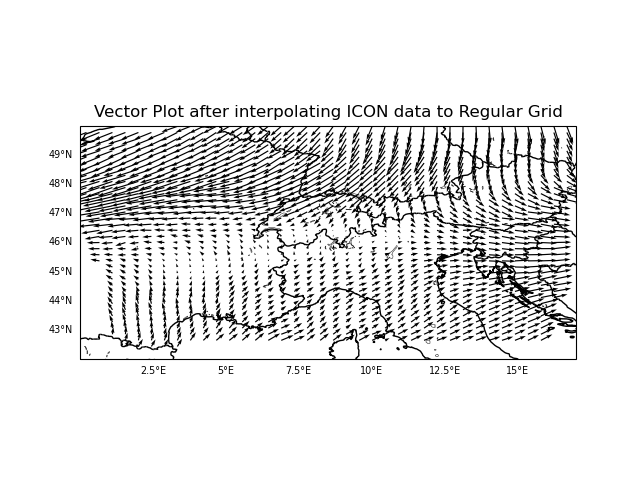

In [48]:
mapvectors = ds_interp.psy.plot.mapvector(time=0,
                                lonlatbox=[0.,17.,42.,50.],
                                map_extent='data',
                                name=[['U', 'V']],
                                density=10, 
                                arrowsize=400, 
                                z_1=8, 
                                borders=True, meanmax_wind=False,
                                title='Vector Plot after interpolating ICON data to Regular Grid')

### Remap ICON grid to coarser ICON grid for wind plotting

In [38]:
out_grid_file='../data/example_data/grids/mch_ch_coarsegrid_wind_R19B04.nc'

output_file_2 = interpolatenew.remap_ICON_to_ICON(data_file=f_icon,
                                        in_grid_file=gridfile,
                                        out_grid_file=out_grid_file, # grid in output, eg R19B04, low resolution
                                        num_dates=ds.time.shape[0] # number of time steps in your data.
                                              ) 

print('Interpolated data stored at: '+ str(output_file_2))


Fieldextra Namelist saved to:/scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/NAMELIST_ICON_ICON_REMAP

Running fieldextra:/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp tmp/fieldextra/NAMELIST_ICON_ICON_REMAP

SQ %INFO fieldextra: Program successfully completed
Interpolated data stored at: /scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/lfff00000000z_interpolated_ICONgrid.nc
Interpolated data stored at: /scratch-shared/meteoswiss/scratch/vcherkas/icon-vis/vectorplot/tmp/fieldextra/lfff00000000z_interpolated_ICONgrid.nc


In [39]:
ds_interp_2 = psy.open_dataset(output_file_2)

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/psy_maps/plotters.py:1934: RuntimeWarning: Quiver plot of unstructered data does not support the density keyword!
  warnings.warn("Quiver plot of unstructered data does not support "
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationW

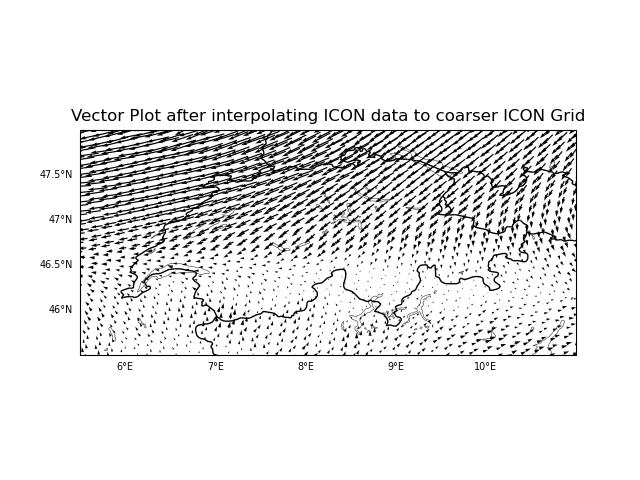

In [42]:
mapvectors = ds_interp_2.psy.plot.mapvector(time=0,
                                map_extent=[5.5, 11.0, 45.5, 48.0], 
                                name=[['U', 'V']],
                                density=15, arrowsize=400, z_1=8, 
                                borders=True, meanmax_wind=False,
                                title='Vector Plot after interpolating ICON data to coarser ICON Grid')

# Stream plot

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


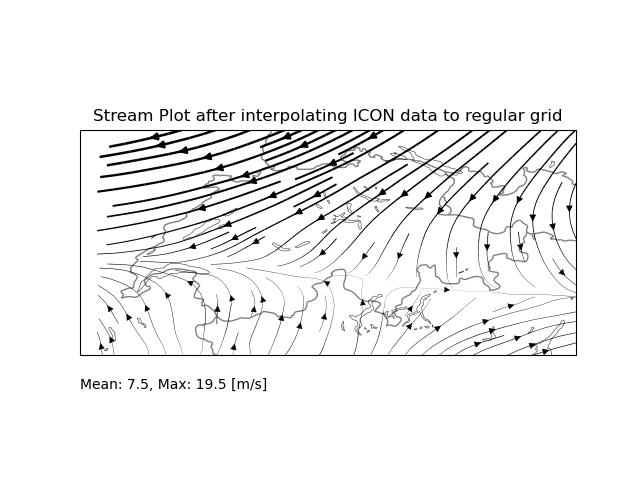

In [44]:
mapvectors = ds_interp.psy.plot.mapvector(time=0,plot='stream', linewidth=['absolute', 0.1],
                                lonlatbox=[5.5, 11.0, 45.5, 48.0], 
                                name=[['U', 'V']],
                                z_1=8, 
                                borders = {'color': 'grey', 'linewidth': 1.0},
                                xgrid=None, ygrid=None, meanmax_wind=True,
                                title='Stream Plot after interpolating ICON data to regular grid')

# Quiver plot - example with ICON data, before interpolation to coarser grid.

Result is mainly all black due to high density of arrows. This grid has > 1 million cells.

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/

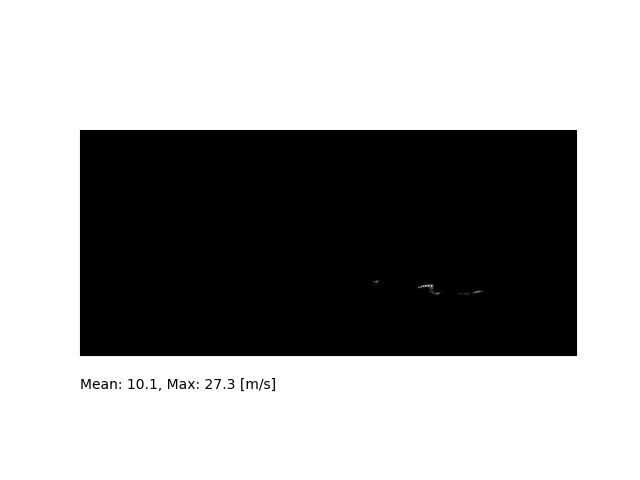

In [27]:
mapvector_1 = psy.plot.mapvector(ds, time=0, plot='quiver',
                                map_extent=[5.5, 11.0, 45.5, 48.0], 
                                name=[['U', 'V']],
                                arrowsize=100, 
                                borders=True)